## Feature Selection and Engineering

In [1]:
import numpy as np
import pandas as pd
import sklearn
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import scipy
from scipy import signal
from biosppy.signals import ecg
from biosppy.signals import eeg
from biosppy.signals import resp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import tqdm 
from tqdm import tqdm 
from IPython.core.display import display, HTML

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
print("Train Data Shape ====>", train_data.shape)
print('\n')
print("Test Data Shape ====>", test_data.shape)

Train Data Shape ====> (4867421, 28)


Test Data Shape ====> (17965143, 28)


* Here we sort the dataframe according to crew and then time. This sorted data frame will be more meaningful when we try to do other operations because each type of experiment shows a different type of characteristics.

In [3]:
train_data.columns

Index(['crew', 'experiment', 'time', 'seat', 'eeg_fp1', 'eeg_f7', 'eeg_f8',
       'eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3',
       'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz',
       'eeg_c3', 'eeg_cz', 'eeg_o2', 'ecg', 'r', 'gsr', 'event'],
      dtype='object')

### Deriving Hear Beat Information from ECG

In [4]:
# Define the data and sampling rate
ecg_data = train_data["ecg"]
sampling_rate = 256

# Extracting the ECG features for each experiment type
ecg_bio_ca = ecg.ecg(ecg_data[train_data['experiment'] == 'CA'], sampling_rate=sampling_rate, show=False)
ecg_bio_da = ecg.ecg(ecg_data[train_data['experiment'] == 'DA'], sampling_rate=sampling_rate, show=False)
ecg_bio_ss = ecg.ecg(ecg_data[train_data['experiment'] == 'SS'], sampling_rate=sampling_rate, show=False)

# Printing the available features for one of the ECG data types
print(list(ecg_bio_ca.keys()))

['ts', 'filtered', 'rpeaks', 'templates_ts', 'templates', 'heart_rate_ts', 'heart_rate']


In [5]:
print(ecg_bio_ca["heart_rate_ts"].shape)

(5486,)


* The output heart rate from the biosppy module is at some particular timesteps. The heart rate corresponding to all the timestamps in our data set is not available. So we need to find out these values. Interpolation is used for this purpose

In [7]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html
# Defining a function that performs linear interpolation on the given values
def interpolate_values(timestamps, biosppy_ts, biosppy_values):
    """Linear interpolation function to produce heart rate at all time steps"""
    interpolation = interp1d(biosppy_ts, biosppy_values, kind="linear", fill_value="extrapolate")
    # The 'kind' parameter sets the type of interpolation to perform, and the 'fill_value' parameter sets the value to use for any extrapolated points.
    return interpolation(timestamps)

In [8]:
def interpolate_values(timestamps, biosppy_ts, biosppy_values):
    """Linear interpolation function to produce heart rate at all time steps"""
    interpolation = interp1d(biosppy_ts, biosppy_values, kind="linear", fill_value="extrapolate")
    return interpolation(timestamps)

# Defining the experiment types
experiment_types = ['CA', 'DA', 'SS']

# Extract heart rate data for each experiment type using the interpolation function
heart_rate_data = []
for experiment_type in experiment_types:
    timestamps = train_data[train_data['experiment'] == experiment_type]['time']
    biosppy_ts = ecg_bio_ca['heart_rate_ts']
    biosppy_values = ecg_bio_ca['heart_rate']
    heart_rate = interpolate_values(timestamps, biosppy_ts, biosppy_values)
    heart_rate_data.append(heart_rate)

# Concatenate the heart rate data for each experiment type
heart_rate = np.concatenate(heart_rate_data)
print(heart_rate.shape)

# Add the heart rate feature to the train data
train_data['heart_rate'] = heart_rate

(4867421,)


In [9]:
print(train_data["heart_rate"])

0          165.735724
1          165.665848
2          165.595971
3          165.526094
4          165.456217
              ...    
4867416     48.903183
4867417     48.913310
4867418     48.918370
4867419     48.933563
4867420     48.938623
Name: heart_rate, Length: 4867421, dtype: float64


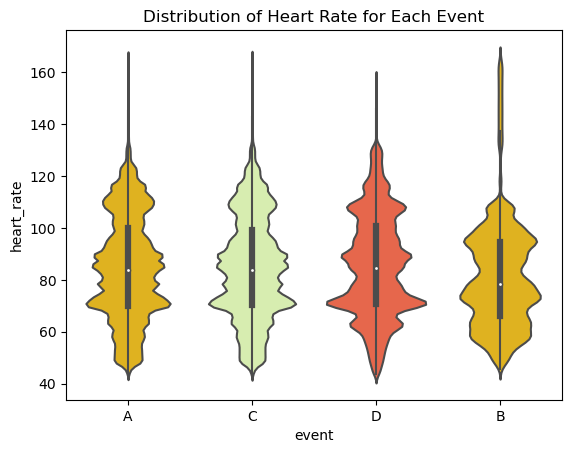

In [10]:
colors = ['#FFC300', '#DAF7A6', '#FF5733']

sns.violinplot(x='event', y='heart_rate', data=train_data, palette=colors)

plt.title("Distribution of Heart Rate for Each Event")
plt.show()

* Heart rate consists of so much noise.
* From the box plot we can understand that heart rate is an important feature, if the heart rate is maximum then it mostly like to be event B.


### Deriving Respiration Rate Information from respiration

In [11]:
r_bio_ca = resp.resp(train_data[train_data['experiment'] == 'CA']['r'], sampling_rate=256, show=False)
r_bio_da = resp.resp(train_data[train_data['experiment'] == 'DA']['r'], sampling_rate=256, show=False)
r_bio_ss = resp.resp(train_data[train_data['experiment'] == 'SS']['r'], sampling_rate=256, show=False)

print(r_bio_ca.keys())

['ts', 'filtered', 'zeros', 'resp_rate_ts', 'resp_rate']


In [12]:
resp_rate_ca = interpolation_fn(train_data[train_data["experiment"]=="CA"]["time"], r_bio_ca["resp_rate_ts"], r_bio_ca["resp_rate"])
resp_rate_da = interpolation_fn(train_data[train_data["experiment"]=="DA"]["time"], r_bio_da["resp_rate_ts"], r_bio_da["resp_rate"])
resp_rate_ss = interpolation_fn(train_data[train_data["experiment"]=="SS"]["time"], r_bio_ss["resp_rate_ts"], r_bio_ss["resp_rate"])

resp_rate = np.concatenate((resp_rate_ca, resp_rate_da, resp_rate_ss))

# Add the respiration rate feature to the train_data DataFrame
train_data["resp_rate"] = resp_rate

print(resp_rate.shape)

(4867421,)


In [13]:
print(train_data['resp_rate'])

0          0.105305
1          0.105312
2          0.105320
3          0.105328
4          0.105336
             ...   
4867416    0.202709
4867417    0.202700
4867418    0.202696
4867419    0.202682
4867420    0.202677
Name: resp_rate, Length: 4867421, dtype: float64


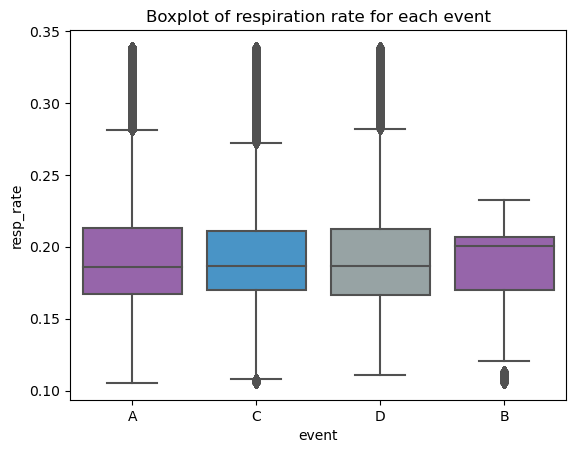

In [14]:
colors = ["#9b59b6", "#3498db", "#95a5a6"]

sns.boxplot(x="event", y="resp_rate", data=train_data, palette=colors)

plt.title("Boxplot of respiration rate for each event")

plt.show()

* Respiration rate consist of so much noise

### Deriving potential difference from electrodes

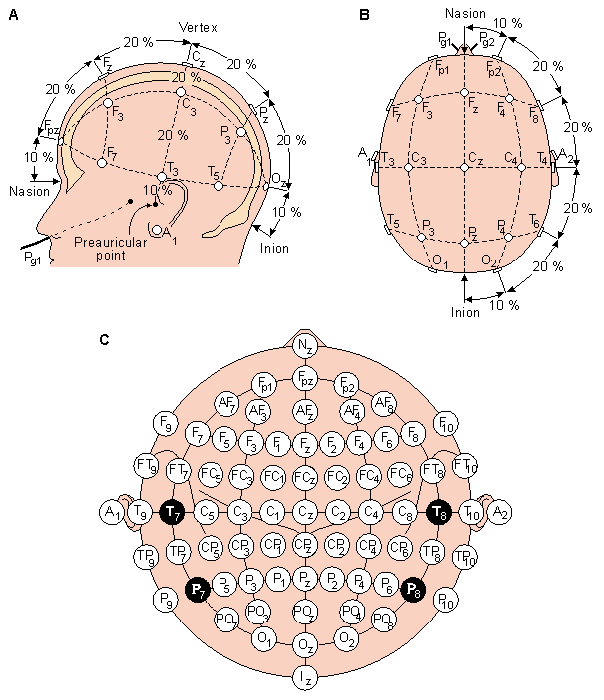

In [15]:
from IPython.display import Image
Image("ElectrodePositions1020.png")

Figure shows 20 different combination of 20 electrodes that are used to calculate the potential dfference.

In [16]:
train_data["fp1_f7"]=train_data["eeg_fp1"]-train_data["eeg_f7"]
train_data["f7_t3"]=train_data["eeg_f7"]-train_data["eeg_t3"]
train_data["t3_t5"]=train_data["eeg_t3"]-train_data["eeg_t5"]
train_data["t5_o1"]=train_data["eeg_t5"]-train_data["eeg_o1"]
train_data["p3_o1"]=train_data["eeg_p3"]-train_data["eeg_o1"]
train_data["c3_p3"]=train_data["eeg_c3"]-train_data["eeg_p3"]
train_data["f3_c3"]=train_data["eeg_f3"]-train_data["eeg_c3"]
train_data["fp1_f3"]=train_data["eeg_fp1"]-train_data["eeg_f3"]

train_data["fz_cz"]=train_data["eeg_fz"]-train_data["eeg_cz"]
train_data["cz_pz"]=train_data["eeg_cz"]-train_data["eeg_pz"]

train_data["fp2_f4"]=train_data["eeg_fp2"]-train_data["eeg_f4"]
train_data["f4_c4"]=train_data["eeg_f4"]-train_data["eeg_c4"]
train_data["c4_p4"]=train_data["eeg_c4"]-train_data["eeg_p4"]
train_data["p4_o2"]=train_data["eeg_p4"]-train_data["eeg_o2"]
train_data["t6_o2"]=train_data["eeg_t6"]-train_data["eeg_o2"]
train_data["t4_t6"]=train_data["eeg_t4"]-train_data["eeg_t6"]
train_data["f8_t4"]=train_data["eeg_f8"]-train_data["eeg_t4"]
train_data["fp2_f8"]=train_data["eeg_fp2"]-train_data["eeg_f8"]

## Deriving Frequency Bands from EEG data

In [17]:
eeg_features = ["eeg_fp1", "eeg_f7", "eeg_f8", "eeg_t4", "eeg_t6", "eeg_t5", "eeg_t3", "eeg_fp2", "eeg_o1",
                "eeg_p3", "eeg_pz", "eeg_f3", "eeg_fz", "eeg_f4", "eeg_c4", "eeg_p4", "eeg_poz", "eeg_c3", "eeg_cz", "eeg_o2"]

eeg.get_power_features will return the frequency bands for each of 20 electrode signals. So, we pass the whole eeg data for eeg matrix as the input to the biosppy and derive all the frequency bands- aplha, beta and gamma from it.

In [18]:
eeg_bio_ca=eeg.get_power_features(train_data[train_data["experiment"]=="CA"][eeg_features],sampling_rate=256)
eeg_bio_da=eeg.get_power_features(train_data[train_data["experiment"]=="DA"][eeg_features],sampling_rate=256)
eeg_bio_ss=eeg.get_power_features(train_data[train_data["experiment"]=="SS"][eeg_features],sampling_rate=256)
print(eeg_bio_ca.keys())

['ts', 'theta', 'alpha_low', 'alpha_high', 'beta', 'gamma']


The outputs from eeg.get_power_features contains 5 frequency bands: Theta: 4 to 8 Hz, Lower Aplha: 8 to 10 Hz, Higher Alpha: 10 to 13 Hz, Beta: 13 to 25 Hz, Gamma: 25 to 40 Hz.

In [19]:
eeg_bio_ca['theta'][0]

array([0.00596342, 0.00315863, 0.00877005, 0.01876262, 0.01764817,
       0.01551566, 0.02829887, 0.0053017 , 0.01167158, 0.03159987,
       0.00630315, 0.00748329, 0.02444151, 0.00398584, 0.00148314,
       0.01699546, 0.01162901, 0.01035285, 0.06036249, 0.02282472])

We need to derive these frequency band information for each of the eeg electrodes

In [20]:
theta_feature = [i + "_theta" for i in eeg_features]

for i in tqdm(range(20)):
    # Interpolate the theta frequency band and store the data in the dataframe
    theta_ca = interpolation_fn(train_data[train_data["experiment"]=="CA"]['time'], eeg_bio_ca["ts"], eeg_bio_ca["theta"][:, i])
    theta_da = interpolation_fn(train_data[train_data["experiment"]=="DA"]['time'], eeg_bio_da["ts"], eeg_bio_da["theta"][:, i])
    theta_ss = interpolation_fn(train_data[train_data["experiment"]=="SS"]['time'], eeg_bio_ss["ts"], eeg_bio_ss["theta"][:, i])
    
    theta = np.concatenate((theta_ca, theta_da, theta_ss))
    
    train_data[theta_feature[i]] = theta

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:30<00:00,  4.52s/it]


In [21]:
alpha_low_feature = [f"{f}_alpha_low" for f in eeg_features]

for i in tqdm(range(20)):
    # Take the alpha_low frequency band and do the interpolation and store the data in the dataframe
    alpha_low = []
    for experiment, eeg_bio in [("CA", eeg_bio_ca), ("DA", eeg_bio_da), ("SS", eeg_bio_ss)]:
        alpha_low_exp = interpolation_fn(
            train_data[train_data["experiment"] == experiment]["time"],
            eeg_bio["ts"], eeg_bio["alpha_low"][:, i])
        alpha_low.append(alpha_low_exp)
    
    alpha_low = np.concatenate(alpha_low)
    train_data[alpha_low_feature[i]] = alpha_low 

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:59<00:00,  5.96s/it]


In [22]:
alpha_high_feature = [f"{f}_alpha_high" for f in eeg_features]

for i in tqdm(range(20)):
    # Take the alpha_high frequency band and do the interpolation and store the data in the dataframe
    alpha_high = []
    for experiment, eeg_bio in [("CA", eeg_bio_ca), ("DA", eeg_bio_da), ("SS", eeg_bio_ss)]:
        alpha_high_exp = interpolation_fn(
            train_data[train_data["experiment"] == experiment]["time"],
            eeg_bio["ts"], eeg_bio["alpha_high"][:, i])
        alpha_high.append(alpha_high_exp)
    
    alpha_high = np.concatenate(alpha_high)
    train_data[alpha_high_feature[i]] = alpha_high

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:00<00:00,  9.01s/it]


In [23]:
beta_feature = [f"{f}_beta" for f in eeg_features]

for i in tqdm(range(20)):
    # Take the beta frequency band and do the interpolation and store the data in the dataframe
    beta = []
    for experiment, eeg_bio in [("CA", eeg_bio_ca), ("DA", eeg_bio_da), ("SS", eeg_bio_ss)]:
        beta_exp = interpolation_fn(
            train_data[train_data["experiment"] == experiment]["time"],
            eeg_bio["ts"], eeg_bio["beta"][:, i])
        beta.append(beta_exp)
    
    beta = np.concatenate(beta)
    train_data[beta_feature[i]] = beta

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:01<00:00, 12.09s/it]


In [24]:
gamma_feature = [f"{f}_gamma" for f in eeg_features]

for i in tqdm(range(20)):
    # Take the gamma frequency band and do the interpolation and store the data in the dataframe
    gamma = []
    for experiment, eeg_bio in [("CA", eeg_bio_ca), ("DA", eeg_bio_da), ("SS", eeg_bio_ss)]:
        gamma_exp = interpolation_fn(
            train_data[train_data["experiment"] == experiment]["time"],
            eeg_bio["ts"], eeg_bio["gamma"][:, i])
        gamma.append(gamma_exp)
    
    gamma = np.concatenate(gamma)
    train_data[gamma_feature[i]] = gamma

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [10:43<00:00, 32.19s/it]


#### Replacement of 'event' column, using the corresponding label encoded representation

In [25]:
# encoding output class
d={'A':0,'B':1,'C':2,'D':3}
e=train_data["event"]
e=list(map(lambda i:d[i],e))
train_data["e"]=e

In [26]:
train_data['e'].value_counts()

0    2848809
2    1652686
3     235329
1     130597
Name: e, dtype: int64

In [27]:
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
crew,4867421.0,5.538783,3.409353,1.000000,3.000000,5.000000,7.000000,13.000000
time,4867421.0,178.235843,103.959165,0.003000,88.081001,176.929688,268.339844,360.371094
seat,4867421.0,0.499953,0.500000,0.000000,0.000000,0.000000,1.000000,1.000000
eeg_fp1,4867421.0,3.746336,45.067626,-1361.359985,-9.200250,0.381902,10.306100,1972.239990
eeg_f7,4867421.0,1.360002,35.189228,-1581.329956,-8.325150,0.042641,8.753340,2048.790039
...,...,...,...,...,...,...,...,...
eeg_poz_gamma,4867421.0,0.001116,0.001149,0.000125,0.000632,0.000888,0.001255,0.027033
eeg_c3_gamma,4867421.0,0.001971,0.005968,0.000183,0.000780,0.001109,0.001637,0.158598
eeg_cz_gamma,4867421.0,0.000960,0.001127,0.000116,0.000518,0.000744,0.001062,0.027981
eeg_o2_gamma,4867421.0,0.001764,0.001785,0.000219,0.001015,0.001446,0.002037,0.066412


In [28]:
train_data.columns

Index(['crew', 'experiment', 'time', 'seat', 'eeg_fp1', 'eeg_f7', 'eeg_f8',
       'eeg_t4', 'eeg_t6', 'eeg_t5',
       ...
       'eeg_f3_gamma', 'eeg_fz_gamma', 'eeg_f4_gamma', 'eeg_c4_gamma',
       'eeg_p4_gamma', 'eeg_poz_gamma', 'eeg_c3_gamma', 'eeg_cz_gamma',
       'eeg_o2_gamma', 'e'],
      dtype='object', length=149)

### Removing unimportant features from the dataset using Correlation

In [29]:
g=["e","crew","seat","r","ecg","heart_rate","resp_rate"]
train_data[g].corr()

,e,crew,seat,r,ecg,heart_rate,resp_rate
e,1.000000,-0.013677,-0.000034,-0.003308,-0.051368,-0.000157,-0.001890
crew,-0.013677,1.000000,-0.000026,0.017672,-0.092310,-0.000544,-0.048573
seat,-0.000034,-0.000026,1.000000,0.895856,0.065637,-0.000176,0.000067
r,-0.003308,0.017672,0.895856,1.000000,0.049906,-0.000986,0.014445
ecg,-0.051368,-0.092310,0.065637,0.049906,1.000000,0.001223,-0.040256
heart_rate,-0.000157,-0.000544,-0.000176,-0.000986,0.001223,1.000000,0.060016
resp_rate,-0.001890,-0.048573,0.000067,0.014445,-0.040256,0.060016,1.000000


* Effect of crew and ecg for predicting the event is high
* Feature sear is less correlated with event so that we can remove that feature

In [30]:
g=["e"]
g.extend(eeg_features)
g.extend(["fp1_f7","f7_t3","t3_t5","t5_o1","p3_o1","c3_p3","f3_c3","fp1_f3","fz_cz",
"cz_pz","fp2_f4","f4_c4","c4_p4","p4_o2","t6_o2","t4_t6","f8_t4","fp2_f8"])
train_data[g].corr()

,e,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,...,fz_cz,cz_pz,fp2_f4,f4_c4,c4_p4,p4_o2,t6_o2,t4_t6,f8_t4,fp2_f8
e,1.000000,-0.018637,-0.005745,-0.005377,0.000721,-0.000426,0.000790,0.001524,-0.016133,0.000552,...,-0.004606,-0.001366,-0.010282,-0.002993,-0.009157,0.001010,0.001071,0.001195,-0.007492,-0.017992
eeg_fp1,-0.018637,1.000000,0.649661,0.561712,0.434736,0.328606,0.332473,0.412335,0.808817,0.230432,...,0.239841,0.010353,0.456736,0.126063,0.233332,0.006739,-0.046448,0.219985,0.333259,0.568954
eeg_f7,-0.005745,0.649661,1.000000,0.493707,0.454118,0.309661,0.466838,0.510271,0.666813,0.158739,...,0.147599,0.071693,0.429563,0.038284,0.135325,0.028873,-0.010776,0.258509,0.229466,0.434163
eeg_f8,-0.005377,0.561712,0.493707,1.000000,0.624069,0.428697,0.367796,0.361123,0.743647,0.201592,...,0.222028,0.063498,0.422059,0.057475,0.294497,0.065091,0.054573,0.352563,0.725337,-0.028120
eeg_t4,0.000721,0.434736,0.454118,0.624069,1.000000,0.537165,0.398861,0.509766,0.520755,0.271376,...,0.211830,0.011433,0.228751,0.090384,0.084652,0.007047,0.072487,0.692963,-0.085230,0.067178
eeg_t6,-0.000426,0.328606,0.309661,0.428697,0.537165,1.000000,0.496123,0.387109,0.370542,0.341525,...,0.066483,-0.015075,0.101095,0.005026,0.056896,0.024574,0.328395,-0.235888,0.073404,0.065308
eeg_t5,0.000790,0.332473,0.466838,0.367796,0.398861,0.496123,1.000000,0.528224,0.355093,0.356271,...,0.081885,0.071967,0.166531,-0.057288,0.083599,-0.040627,-0.050045,0.035466,0.117593,0.111635
eeg_t3,0.001524,0.412335,0.510271,0.361123,0.509766,0.387109,0.528224,1.000000,0.367574,0.270236,...,0.126183,0.024082,0.174775,0.004102,0.061917,0.003395,-0.015443,0.256422,0.011376,0.137903
eeg_fp2,-0.016133,0.808817,0.666813,0.743647,0.520755,0.370542,0.355093,0.367574,1.000000,0.189598,...,0.222368,0.052575,0.618618,0.115691,0.292355,0.034425,-0.010811,0.283242,0.489470,0.647397
eeg_o1,0.000552,0.230432,0.158739,0.201592,0.271376,0.341525,0.356271,0.270236,0.189598,1.000000,...,0.016638,-0.204951,0.047391,-0.027786,-0.068439,-0.291604,-0.334342,0.020732,0.017975,0.053666


Potential differences are having more impact in predicting the events as compared to the simple eeg electrode data

In [31]:
#correlation between theta frequency and features and event
theta_feature=[i+"_theta" for i in eeg_features]
g=["e"]
g.extend(theta_feature)
train_data[g].corr()

,e,eeg_fp1_theta,eeg_f7_theta,eeg_f8_theta,eeg_t4_theta,eeg_t6_theta,eeg_t5_theta,eeg_t3_theta,eeg_fp2_theta,eeg_o1_theta,...,eeg_pz_theta,eeg_f3_theta,eeg_fz_theta,eeg_f4_theta,eeg_c4_theta,eeg_p4_theta,eeg_poz_theta,eeg_c3_theta,eeg_cz_theta,eeg_o2_theta
e,1.000000,-0.015906,-0.016243,-0.017989,-0.017477,-0.017495,-0.019968,-0.017832,-0.017133,-0.016306,...,-0.010520,-0.016555,-0.021953,-0.017584,-0.016833,-0.016754,-0.016649,-0.017090,-0.022415,-0.011300
eeg_fp1_theta,-0.015906,1.000000,0.978809,0.951739,0.946216,0.957623,0.881119,0.950430,0.984786,0.964369,...,0.196622,0.980978,0.367054,0.963531,0.971050,0.967328,0.968516,0.969389,0.341873,0.182145
eeg_f7_theta,-0.016243,0.978809,1.000000,0.936553,0.955280,0.967297,0.896253,0.966020,0.956895,0.973400,...,0.183573,0.987675,0.339949,0.961439,0.974894,0.976739,0.978029,0.979674,0.318915,0.183405
eeg_f8_theta,-0.017989,0.951739,0.936553,1.000000,0.964141,0.971749,0.943877,0.970197,0.980087,0.952585,...,0.232198,0.965446,0.411448,0.986266,0.981279,0.973971,0.968828,0.970608,0.333605,0.255735
eeg_t4_theta,-0.017477,0.946216,0.955280,0.964141,1.000000,0.967305,0.936038,0.984338,0.960629,0.950798,...,0.189679,0.976192,0.327758,0.991521,0.977274,0.975751,0.968769,0.975666,0.290077,0.229870
eeg_t6_theta,-0.017495,0.957623,0.967297,0.971749,0.967305,1.000000,0.943300,0.983822,0.964587,0.980770,...,0.216267,0.986085,0.384636,0.979688,0.992053,0.992842,0.991646,0.990666,0.329996,0.211890
eeg_t5_theta,-0.019968,0.881119,0.896253,0.943877,0.936038,0.943300,1.000000,0.967331,0.908817,0.914001,...,0.218463,0.930501,0.384439,0.949772,0.945936,0.946626,0.939372,0.947362,0.287247,0.422712
eeg_t3_theta,-0.017832,0.950430,0.966020,0.970197,0.984338,0.983822,0.967331,1.000000,0.960068,0.967365,...,0.201191,0.986352,0.354590,0.990048,0.989284,0.990200,0.985203,0.991769,0.291802,0.266310
eeg_fp2_theta,-0.017133,0.984786,0.956895,0.980087,0.960629,0.964587,0.908817,0.960068,1.000000,0.958526,...,0.216861,0.975839,0.385545,0.980614,0.977895,0.971339,0.969184,0.970698,0.336927,0.204112
eeg_o1_theta,-0.016306,0.964369,0.973400,0.952585,0.950798,0.980770,0.914001,0.967365,0.958526,1.000000,...,0.217401,0.984592,0.393714,0.963120,0.985887,0.988240,0.993335,0.988314,0.358742,0.202049


Theta feature is having some considerable effect in events. The correlation is considerable. So this feature will be useful in predicting the event

In [32]:
#correlation between alpha low frequency abnd features and event
g=["e"]
g.extend(alpha_low_feature)
train_data[g].corr()

,e,eeg_fp1_alpha_low,eeg_f7_alpha_low,eeg_f8_alpha_low,eeg_t4_alpha_low,eeg_t6_alpha_low,eeg_t5_alpha_low,eeg_t3_alpha_low,eeg_fp2_alpha_low,eeg_o1_alpha_low,...,eeg_pz_alpha_low,eeg_f3_alpha_low,eeg_fz_alpha_low,eeg_f4_alpha_low,eeg_c4_alpha_low,eeg_p4_alpha_low,eeg_poz_alpha_low,eeg_c3_alpha_low,eeg_cz_alpha_low,eeg_o2_alpha_low
e,1.000000,-0.018524,-0.017802,-0.021522,-0.018996,-0.020430,-0.020151,-0.017320,-0.016788,-0.014296,...,-0.004906,-0.016190,-0.022408,-0.018538,-0.018084,-0.019533,-0.015879,-0.018446,-0.014437,-0.013909
eeg_fp1_alpha_low,-0.018524,1.000000,0.771483,0.776984,0.669622,0.685589,0.676602,0.696074,0.902015,0.706123,...,0.165838,0.782604,0.317371,0.793727,0.715071,0.701665,0.704220,0.738921,0.180084,0.217450
eeg_f7_alpha_low,-0.017802,0.771483,1.000000,0.767156,0.727534,0.762320,0.780669,0.824048,0.718910,0.808635,...,0.190041,0.892374,0.309855,0.800316,0.784894,0.789299,0.798707,0.865974,0.201806,0.249156
eeg_f8_alpha_low,-0.021522,0.776984,0.767156,1.000000,0.773205,0.773558,0.711848,0.695412,0.819736,0.743774,...,0.183674,0.789077,0.284239,0.867621,0.801821,0.780317,0.751895,0.768997,0.184736,0.253332
eeg_t4_alpha_low,-0.018996,0.669622,0.727534,0.773205,1.000000,0.783415,0.731118,0.709082,0.661360,0.743043,...,0.150964,0.744871,0.240722,0.796555,0.790192,0.785140,0.749473,0.742053,0.178516,0.252550
eeg_t6_alpha_low,-0.020430,0.685589,0.762320,0.773558,0.783415,1.000000,0.765104,0.751928,0.673122,0.808191,...,0.166881,0.778340,0.236887,0.792897,0.817757,0.894247,0.823046,0.794215,0.168491,0.269897
eeg_t5_alpha_low,-0.020151,0.676602,0.780669,0.711848,0.731118,0.765104,1.000000,0.815923,0.652914,0.853822,...,0.163137,0.780941,0.243479,0.750717,0.744146,0.796163,0.831794,0.808658,0.146064,0.396420
eeg_t3_alpha_low,-0.017320,0.696074,0.824048,0.695412,0.709082,0.751928,0.815923,1.000000,0.662095,0.810855,...,0.176707,0.813760,0.285426,0.740114,0.748820,0.776625,0.791149,0.825571,0.190108,0.260919
eeg_fp2_alpha_low,-0.016788,0.902015,0.718910,0.819736,0.661360,0.673122,0.652914,0.662095,1.000000,0.689444,...,0.172381,0.750380,0.305247,0.806925,0.712441,0.692799,0.692583,0.712161,0.183382,0.208305
eeg_o1_alpha_low,-0.014296,0.706123,0.808635,0.743774,0.743043,0.808191,0.853822,0.810855,0.689444,1.000000,...,0.193739,0.810789,0.236734,0.785266,0.790493,0.861599,0.929963,0.847566,0.173372,0.272322


From this plot we can see that, compared to the 20 eeg electrode data, the alpha low frequency bands derived from this eeg is having more effect in determining the events

In [33]:
#correlation between alpha high features and event
g=["e"]
g.extend(alpha_high_feature)
train_data[g].corr()

,e,eeg_fp1_alpha_high,eeg_f7_alpha_high,eeg_f8_alpha_high,eeg_t4_alpha_high,eeg_t6_alpha_high,eeg_t5_alpha_high,eeg_t3_alpha_high,eeg_fp2_alpha_high,eeg_o1_alpha_high,...,eeg_pz_alpha_high,eeg_f3_alpha_high,eeg_fz_alpha_high,eeg_f4_alpha_high,eeg_c4_alpha_high,eeg_p4_alpha_high,eeg_poz_alpha_high,eeg_c3_alpha_high,eeg_cz_alpha_high,eeg_o2_alpha_high
e,1.000000,-0.007643,-0.020279,-0.011388,-0.016148,-0.016895,-0.015357,-0.012556,-0.003920,-0.010687,...,-0.008124,-0.014971,-0.020630,-0.013006,-0.009771,-0.011985,-0.007244,-0.018254,-0.009468,-0.011225
eeg_fp1_alpha_high,-0.007643,1.000000,0.641747,0.633873,0.534634,0.561781,0.600948,0.547241,0.786918,0.618990,...,0.171653,0.655877,0.310571,0.700107,0.601663,0.613234,0.627849,0.645599,0.188423,0.221174
eeg_f7_alpha_high,-0.020279,0.641747,1.000000,0.631203,0.550670,0.542987,0.590007,0.606044,0.617343,0.628345,...,0.182196,0.789591,0.302013,0.654617,0.627637,0.604533,0.617618,0.729622,0.234152,0.231483
eeg_f8_alpha_high,-0.011388,0.633873,0.631203,1.000000,0.577316,0.587816,0.555937,0.511538,0.704545,0.608319,...,0.197617,0.640267,0.323976,0.725861,0.659268,0.628481,0.612145,0.665875,0.257725,0.211689
eeg_t4_alpha_high,-0.016148,0.534634,0.550670,0.577316,1.000000,0.602326,0.587090,0.554868,0.538256,0.577242,...,0.144221,0.567646,0.235338,0.629252,0.654409,0.634094,0.589368,0.606830,0.194054,0.230433
eeg_t6_alpha_high,-0.016895,0.561781,0.542987,0.587816,0.602326,1.000000,0.671991,0.580917,0.606907,0.691905,...,0.190428,0.562410,0.222282,0.648077,0.647477,0.798925,0.709132,0.629957,0.168793,0.344372
eeg_t5_alpha_high,-0.015357,0.600948,0.590007,0.555937,0.587090,0.671991,1.000000,0.693777,0.616248,0.778629,...,0.184683,0.616397,0.245092,0.660664,0.631932,0.731408,0.749100,0.704245,0.169627,0.389896
eeg_t3_alpha_high,-0.012556,0.547241,0.606044,0.511538,0.554868,0.580917,0.693777,1.000000,0.575046,0.646824,...,0.186562,0.601803,0.261312,0.582559,0.599607,0.639931,0.638754,0.638604,0.194836,0.257872
eeg_fp2_alpha_high,-0.003920,0.786918,0.617343,0.704545,0.538256,0.606907,0.616248,0.575046,1.000000,0.680341,...,0.199282,0.654503,0.327415,0.734572,0.642212,0.668104,0.685140,0.683906,0.217454,0.215439
eeg_o1_alpha_high,-0.010687,0.618990,0.628345,0.608319,0.577242,0.691905,0.778629,0.646824,0.680341,1.000000,...,0.248634,0.647674,0.270615,0.695979,0.687556,0.816683,0.912024,0.766817,0.221666,0.299788


From this plot, we can see that, compared to the 20 eeg electrode data, the alpha high frequency bands derived from this eeg is having more effect in determining the events

In [34]:
#correlation between beta features and event
beta_feature=[i+"_beta" for i in eeg_features]
g=["e"]
g.extend(beta_feature)
train_data[g].corr()

,e,eeg_fp1_beta,eeg_f7_beta,eeg_f8_beta,eeg_t4_beta,eeg_t6_beta,eeg_t5_beta,eeg_t3_beta,eeg_fp2_beta,eeg_o1_beta,...,eeg_pz_beta,eeg_f3_beta,eeg_fz_beta,eeg_f4_beta,eeg_c4_beta,eeg_p4_beta,eeg_poz_beta,eeg_c3_beta,eeg_cz_beta,eeg_o2_beta
e,1.000000,0.001643,-0.017053,0.004255,-0.009884,-0.017834,-0.003506,-0.000822,0.016945,-0.000802,...,-0.001638,-0.007983,0.000420,0.005874,0.002397,-0.003705,0.000755,-0.006130,0.004516,-0.011660
eeg_fp1_beta,0.001643,1.000000,0.276399,0.419063,0.255013,0.269498,0.279435,0.226822,0.680347,0.403122,...,0.279363,0.440232,0.342579,0.523967,0.310106,0.432494,0.443448,0.267210,0.274289,0.330946
eeg_f7_beta,-0.017053,0.276399,1.000000,0.443759,0.307527,0.193236,0.183679,0.285088,0.250341,0.252617,...,0.215023,0.681504,0.279952,0.386916,0.472954,0.275635,0.256204,0.432596,0.225723,0.192627
eeg_f8_beta,0.004255,0.419063,0.443759,1.000000,0.351848,0.276715,0.254776,0.238651,0.514488,0.422326,...,0.380125,0.649093,0.502234,0.627392,0.534881,0.469821,0.453915,0.656879,0.446348,0.347370
eeg_t4_beta,-0.009884,0.255013,0.307527,0.351848,1.000000,0.402292,0.296208,0.423569,0.230704,0.277331,...,0.160805,0.332310,0.211068,0.325971,0.503903,0.444522,0.292761,0.247255,0.176167,0.319534
eeg_t6_beta,-0.017834,0.269498,0.193236,0.276715,0.402292,1.000000,0.294069,0.280381,0.336212,0.497206,...,0.386131,0.265579,0.357260,0.328757,0.279777,0.599514,0.528076,0.202723,0.341786,0.556822
eeg_t5_beta,-0.003506,0.279435,0.183679,0.254776,0.296208,0.294069,1.000000,0.473086,0.320293,0.429647,...,0.303870,0.251390,0.306601,0.320669,0.231442,0.401934,0.392396,0.231731,0.289739,0.294398
eeg_t3_beta,-0.000822,0.226822,0.285088,0.238651,0.423569,0.280381,0.473086,1.000000,0.234154,0.303027,...,0.270484,0.311634,0.296071,0.262800,0.324682,0.362071,0.313950,0.263112,0.260624,0.249673
eeg_fp2_beta,0.016945,0.680347,0.250341,0.514488,0.230704,0.336212,0.320293,0.234154,1.000000,0.542354,...,0.444644,0.472621,0.507615,0.598283,0.358434,0.539791,0.575559,0.338383,0.438062,0.436280
eeg_o1_beta,-0.000802,0.403122,0.252617,0.422326,0.277331,0.497206,0.429647,0.303027,0.542354,1.000000,...,0.662168,0.429073,0.623542,0.530153,0.408561,0.761894,0.897750,0.384159,0.618313,0.736399


The beta frequency bands derived from this eeg is has some effect in determining the events. But the correlation is not very high. Its effect might be similar to the effect of 20 eeg electrode data in determining the events

In [35]:
#correlation between gamma features and event
gamma_feature=[i+"_gamma" for i in eeg_features]
g=["e"]
g.extend(gamma_feature)
train_data[g].corr()

,e,eeg_fp1_gamma,eeg_f7_gamma,eeg_f8_gamma,eeg_t4_gamma,eeg_t6_gamma,eeg_t5_gamma,eeg_t3_gamma,eeg_fp2_gamma,eeg_o1_gamma,...,eeg_pz_gamma,eeg_f3_gamma,eeg_fz_gamma,eeg_f4_gamma,eeg_c4_gamma,eeg_p4_gamma,eeg_poz_gamma,eeg_c3_gamma,eeg_cz_gamma,eeg_o2_gamma
e,1.000000,-0.010784,-0.019913,-0.007520,-0.015065,-0.018467,-0.007604,-0.000561,0.006682,-0.011352,...,-0.002876,-0.011742,-0.003891,-0.003151,0.001652,-0.008198,-0.010289,-0.007135,-0.004606,-0.016438
eeg_fp1_gamma,-0.010784,1.000000,0.320721,0.227108,0.174582,0.150152,0.169680,0.131581,0.556064,0.248216,...,0.203980,0.295854,0.264552,0.323657,0.130730,0.274247,0.259668,0.154308,0.215362,0.180615
eeg_f7_gamma,-0.019913,0.320721,1.000000,0.652615,0.434630,0.206836,0.175915,0.250586,0.317878,0.325763,...,0.343638,0.814804,0.467282,0.575223,0.471905,0.384273,0.337456,0.610985,0.449182,0.199688
eeg_f8_gamma,-0.007520,0.227108,0.652615,1.000000,0.397734,0.232723,0.151836,0.237789,0.421983,0.425044,...,0.523544,0.721741,0.622141,0.735657,0.591054,0.477987,0.467016,0.654610,0.584557,0.281508
eeg_t4_gamma,-0.015065,0.174582,0.434630,0.397734,1.000000,0.328453,0.239267,0.437920,0.153145,0.220744,...,0.191722,0.320900,0.186639,0.269768,0.402615,0.483271,0.231721,0.237705,0.199156,0.214490
eeg_t6_gamma,-0.018467,0.150152,0.206836,0.232723,0.328453,1.000000,0.191792,0.208210,0.337957,0.419718,...,0.402512,0.161462,0.295697,0.211297,0.133094,0.543920,0.528945,0.104723,0.319064,0.458000
eeg_t5_gamma,-0.007604,0.169680,0.175915,0.151836,0.239267,0.191792,1.000000,0.489692,0.200868,0.393337,...,0.316539,0.126850,0.213757,0.166925,0.098067,0.331060,0.331613,0.122560,0.257014,0.197822
eeg_t3_gamma,-0.000561,0.131581,0.250586,0.237789,0.437920,0.208210,0.489692,1.000000,0.133247,0.252325,...,0.287015,0.228384,0.224937,0.221467,0.182765,0.344026,0.265054,0.215292,0.267903,0.168403
eeg_fp2_gamma,0.006682,0.556064,0.317878,0.421983,0.153145,0.337957,0.200868,0.133247,1.000000,0.516076,...,0.564517,0.378362,0.641686,0.492610,0.230113,0.508544,0.559715,0.294806,0.546419,0.418461
eeg_o1_gamma,-0.011352,0.248216,0.325763,0.425044,0.220744,0.419718,0.393337,0.252325,0.516076,1.000000,...,0.803729,0.392181,0.663001,0.498586,0.296752,0.732322,0.852981,0.359987,0.717814,0.664475


From this plot we can see that, the gamma frequency bands derived from this eeg has only some effect in determining the events

* First of all we remove unimportant features like 'seat' ,experiment'(we want to predict event without knowing the experiment).
* After that we remove derived features such as 'beta' and 'gamma' frequency bands because it has less correlation with the event, so we remove these features also.

In [36]:
train_data=train_data.drop(["seat","experiment",'event'],axis=1) # removing seat,experiment

beta_feature=[i+"_beta" for i in eeg_features]# removing beta features
train_data=train_data.drop(beta_feature,axis=1)

gamma_feature=[i+"_gamma" for i in eeg_features]# removing gamma features
train_data=train_data.drop(gamma_feature,axis=1)

In [37]:
train_data.columns

Index(['crew', 'time', 'eeg_fp1', 'eeg_f7', 'eeg_f8', 'eeg_t4', 'eeg_t6',
       'eeg_t5', 'eeg_t3', 'eeg_fp2',
       ...
       'eeg_f3_alpha_high', 'eeg_fz_alpha_high', 'eeg_f4_alpha_high',
       'eeg_c4_alpha_high', 'eeg_p4_alpha_high', 'eeg_poz_alpha_high',
       'eeg_c3_alpha_high', 'eeg_cz_alpha_high', 'eeg_o2_alpha_high', 'e'],
      dtype='object', length=106)

In [38]:
train_data.to_csv("pilot_train_after_fe") # finally save the all the features after feature engineering step